In [1]:
import time
import os
import tqdm
import pickle as pkl
import string
import random
import argparse

import pyspiel
import numpy as np
from open_spiel.python import policy
from open_spiel.python import rl_environment
from open_spiel.python.algorithms import exploitability
from open_spiel.python.algorithms.policy_aggregator import PolicyAggregator
from open_spiel.python.algorithms.psro_v2 import ( best_response_oracle,
    strategy_selectors,
)
from open_spiel.python.algorithms.psro_v2.psro_v2 import PSROSolver
from open_spiel.python.algorithms.psro_v2.optimization_oracle import AbstractOracle

from samplers import *


def meta_game_to_list(meta_game):
    for i in range(len(meta_game)):
        meta_game[i] = meta_game[i].tolist()
    return meta_game


def debug_iteration(psro, sampler, N, history, verbose=False):
    psro._iterations += 1

    info = {
            "type": "step", 
           }
    
    # Run the Oracle and get the new agent
    first_start = time.time()
    psro.update_agents()
    end = time.time()

    info["oracle_elapse"] = end - first_start

    # Update the payoff matrix
    start = time.time()
    compute_meta_game(psro, sampler, N, history)
    end = time.time()

    info["sims_elapse"] = end - start

    # Run the meta-solver
    start = time.time()
    psro.update_meta_strategies()
    last_end = time.time()

    info["meta_solve_elapse"] = last_end - start

    info["total_elapse"] = (
        info["oracle_elapse"] + info["sims_elapse"] + info["meta_solve_elapse"]
    )
    
    if verbose:
        info["meta_game"] = pkl.dumps(psro.get_meta_game())
        info["meta_strategies"] = pkl.dumps(psro.get_meta_strategies())
        info["policies"] = pkl.dumps(psro.get_policies())
    return info


def get_aggregate_policy(game, PSRO):
    meta_probabilities = PSRO.get_meta_strategies()
    policies = PSRO.get_policies()

    return PolicyAggregator(game).aggregate(
        range(len(policies)), policies, meta_probabilities
    )


def get_exploitability(env, n_players, PSRO):
    policies = get_aggregate_policy(env.game, PSRO)
    return exploitability.nash_conv(env.game, policies)

def generate_data(prd, N, data_dir, sampler, steps=100):
    n_players = 2

    game = pyspiel.load_game_as_turn_based("kuhn_poker", {"players": n_players})

    env = rl_environment.Environment(game)

    random_policy = policy.TabularPolicy(env.game)

    oracle = best_response_oracle.BestResponseOracle(
        game=env.game, policy=random_policy
    )

    agents = [random_policy.__copy__() for _ in range(n_players)]
        
    random_extension = ''.join(random.choice(string.ascii_lowercase) for i in range(8))
    print(random_extension)
    log_file = open(f"{data_dir}/{sampler.__name__}_{N}_{prd}_{random_extension}.dat", "w")

    PSRO = PSROSolver(
        env.game,
        oracle,
        meta_strategy_method="nash",
        initial_policies=agents,
        training_strategy_selector=strategy_selectors.probabilistic,
        sims_per_entry=N,
        sample_from_marginals=True,
        # Oracle kwargs
        symmetric_game=False,
        # prd_iterations=prd,
        # prd_gamma=1e-10,
    )

    exploit = get_exploitability(env, n_players, PSRO)

    info = {
        "type": "init",
        "meta_strategy": "prd",
        "meta_game": pkl.dumps(PSRO.get_meta_game()),
        "meta_strategies": pkl.dumps(PSRO.get_meta_strategies()),
        "policies": pkl.dumps(PSRO.get_policies()),
        "starting_exploit": exploit,
    }
    log_file.write(str(info) + "\n")
    history = initialize_history(PSRO, N)

    for it in tqdm.tqdm(range(steps)):
        info = debug_iteration(PSRO, sampler, N, history)

        info["it"] = it

        exploit = get_exploitability(env, n_players, PSRO)
        info["exploit"] = exploit

        log_file.write(str(info) + "\n")
        log_file.flush()
    
    

    log_file.close()

    return compute_matrix(it + 2, history), get_counts(it+2, history)


def main(prd, N, data_dir, sampler):
    generate_data(prd, N, data_dir, sampler, steps=10)

In [2]:
samplers = [baseline_uniform, 
            variance_sampler, 
            simple_ucb, 
            # random_sampler
            ]
for i in range(10):
    for sampler in samplers:
        generate_data(prd=10000, N=100, data_dir='data_temp', sampler=sampler, steps=15)
        generate_data(prd=10000, N=50, data_dir='data_temp', sampler=sampler, steps=15)
        generate_data(prd=10000, N=20, data_dir='data_temp', sampler=sampler, steps=15)
        generate_data(prd=10000, N=10, data_dir='data_temp', sampler=sampler, steps=15)
        generate_data(prd=10000, N=5, data_dir='data_temp', sampler=sampler, steps=15)

eszdqjvc
Using 100 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


  0%|          | 0/15 [00:00<?, ?it/s]/mnt/c/Users/Geoff/Documents/Hannibal-final/samplers.py:20: RuntimeWarning: invalid value encountered in true_divide
  return meta / counts
/home/geoff/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 13%|█▎        | 2/15 [00:00<00:00, 16.84it/s]

budget=400
budget=900
budget=1600


 27%|██▋       | 4/15 [00:00<00:00, 11.73it/s]

budget=2500
budget=3600


 40%|████      | 6/15 [00:00<00:01,  8.81it/s]

budget=4900
budget=6400


 53%|█████▎    | 8/15 [00:01<00:01,  6.68it/s]

budget=8100


 60%|██████    | 9/15 [00:01<00:01,  5.79it/s]

budget=10000
budget=12100


 67%|██████▋   | 10/15 [00:01<00:01,  4.86it/s]

budget=14400


 73%|███████▎  | 11/15 [00:01<00:00,  4.44it/s]

budget=16900


 80%|████████  | 12/15 [00:02<00:00,  4.00it/s]

budget=19600


 87%|████████▋ | 13/15 [00:02<00:00,  3.61it/s]

budget=22500


 93%|█████████▎| 14/15 [00:02<00:00,  3.32it/s]

budget=25600


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


xdrohzvb
Using 50 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 20%|██        | 3/15 [00:00<00:00, 29.76it/s]

budget=200
budget=450
budget=800
budget=1250
budget=1800


 40%|████      | 6/15 [00:00<00:00, 18.14it/s]

budget=2450
budget=3200
budget=4050


 60%|██████    | 9/15 [00:00<00:00, 11.87it/s]

budget=5000
budget=6050


 73%|███████▎  | 11/15 [00:00<00:00,  9.91it/s]

budget=7200
budget=8450


 87%|████████▋ | 13/15 [00:01<00:00,  8.17it/s]

budget=9800
budget=11250


100%|██████████| 15/15 [00:01<00:00,  8.66it/s]

budget=12800


piltdxap
Using 20 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 27%|██▋       | 4/15 [00:00<00:00, 33.68it/s]

budget=80
budget=180
budget=320
budget=500
budget=720
budget=980
budget=1280
budget=1620


 73%|███████▎  | 11/15 [00:00<00:00, 17.54it/s]

budget=2000
budget=2420
budget=2880
budget=3380


 87%|████████▋ | 13/15 [00:00<00:00, 16.50it/s]

budget=3920
budget=4500
budget=5120


100%|██████████| 15/15 [00:00<00:00, 16.91it/s]


zdvegfsa
Using 10 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 33%|███▎      | 5/15 [00:00<00:00, 41.83it/s]

budget=40
budget=90
budget=160
budget=250
budget=360
budget=490
budget=640
budget=810


 67%|██████▋   | 10/15 [00:00<00:00, 31.22it/s]

budget=1000
budget=1210
budget=1440
budget=1690
budget=1960


100%|██████████| 15/15 [00:00<00:00, 27.44it/s]


budget=2250
budget=2560
waqxsove
Using 5 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


  0%|          | 0/15 [00:00<?, ?it/s]

budget=20
budget=45
budget=80
budget=125
budget=180
budget=245


 47%|████▋     | 7/15 [00:00<00:00, 54.19it/s]

budget=320
budget=405
budget=500
budget=605
budget=720
budget=845
budget=980


100%|██████████| 15/15 [00:00<00:00, 37.73it/s]


budget=1125
budget=1280
ejeeepqs
Using 100 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


  0%|          | 0/15 [00:00<?, ?it/s]

budget=400
budget=900


 13%|█▎        | 2/15 [00:00<00:01,  6.60it/s]

budget=1600


 20%|██        | 3/15 [00:00<00:02,  4.40it/s]

budget=2500


 27%|██▋       | 4/15 [00:01<00:03,  3.22it/s]

budget=3600


 33%|███▎      | 5/15 [00:01<00:04,  2.24it/s]

budget=4900


 40%|████      | 6/15 [00:02<00:05,  1.67it/s]

budget=6400


 47%|████▋     | 7/15 [00:03<00:06,  1.28it/s]

budget=8100


 53%|█████▎    | 8/15 [00:05<00:07,  1.02s/it]

budget=10000


 60%|██████    | 9/15 [00:07<00:07,  1.30s/it]

budget=12100


 67%|██████▋   | 10/15 [00:09<00:07,  1.59s/it]

budget=14400


 73%|███████▎  | 11/15 [00:12<00:08,  2.08s/it]

budget=16900


 80%|████████  | 12/15 [00:15<00:07,  2.37s/it]

budget=19600


 87%|████████▋ | 13/15 [00:19<00:05,  2.70s/it]

budget=22500


 93%|█████████▎| 14/15 [00:23<00:03,  3.06s/it]

budget=25600


100%|██████████| 15/15 [00:27<00:00,  1.84s/it]


hnxbguxz
Using 50 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 13%|█▎        | 2/15 [00:00<00:00, 15.93it/s]

budget=200
budget=450
budget=800
budget=1250


 27%|██▋       | 4/15 [00:00<00:01,  6.78it/s]

budget=1800


 33%|███▎      | 5/15 [00:00<00:02,  4.93it/s]

budget=2450


 40%|████      | 6/15 [00:01<00:02,  3.67it/s]

budget=3200


 47%|████▋     | 7/15 [00:01<00:02,  2.76it/s]

budget=4050


 53%|█████▎    | 8/15 [00:02<00:03,  1.97it/s]

budget=5000


 60%|██████    | 9/15 [00:03<00:03,  1.67it/s]

budget=6050


 67%|██████▋   | 10/15 [00:04<00:03,  1.34it/s]

budget=7200


 73%|███████▎  | 11/15 [00:05<00:03,  1.11it/s]

budget=8450


 80%|████████  | 12/15 [00:07<00:03,  1.10s/it]

budget=9800


 87%|████████▋ | 13/15 [00:09<00:02,  1.25s/it]

budget=11250


 93%|█████████▎| 14/15 [00:10<00:01,  1.45s/it]

budget=12800


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


wlrngqcq
Using 20 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 20%|██        | 3/15 [00:00<00:00, 23.97it/s]

budget=80
budget=180
budget=320
budget=500
budget=720
budget=980


 40%|████      | 6/15 [00:00<00:00,  9.35it/s]

budget=1280
budget=1620


 53%|█████▎    | 8/15 [00:01<00:01,  6.56it/s]

budget=2000


 60%|██████    | 9/15 [00:01<00:01,  5.25it/s]

budget=2420


 67%|██████▋   | 10/15 [00:01<00:01,  4.15it/s]

budget=2880


 73%|███████▎  | 11/15 [00:02<00:01,  3.32it/s]

budget=3380


 80%|████████  | 12/15 [00:02<00:01,  2.70it/s]

budget=3920


 87%|████████▋ | 13/15 [00:03<00:00,  2.32it/s]

budget=4500


 93%|█████████▎| 14/15 [00:04<00:00,  1.96it/s]

budget=5120


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


ikvlzqhe
Using 10 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 27%|██▋       | 4/15 [00:00<00:00, 26.21it/s]

budget=40
budget=90
budget=160
budget=250
budget=360
budget=490
budget=640


 47%|████▋     | 7/15 [00:00<00:00, 13.21it/s]

budget=810
budget=1000


 60%|██████    | 9/15 [00:00<00:00,  9.38it/s]

budget=1210
budget=1440


 73%|███████▎  | 11/15 [00:01<00:00,  7.17it/s]

budget=1690


 80%|████████  | 12/15 [00:01<00:00,  6.37it/s]

budget=1960


 87%|████████▋ | 13/15 [00:01<00:00,  5.88it/s]

budget=2250


 93%|█████████▎| 14/15 [00:01<00:00,  5.11it/s]

budget=2560


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


gnsgzgsm
Using 5 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 40%|████      | 6/15 [00:00<00:00, 47.15it/s]

budget=20
budget=45
budget=80
budget=125
budget=180
budget=245
budget=320
budget=405


 73%|███████▎  | 11/15 [00:00<00:00, 22.85it/s]

budget=500
budget=605
budget=720
budget=845
budget=980
budget=1125


100%|██████████| 15/15 [00:00<00:00, 17.38it/s]


budget=1280
wmxrjiyi
Using 100 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


  0%|          | 0/15 [00:00<?, ?it/s]

budget=400
budget=900
budget=1600
budget=2500


 53%|█████▎    | 8/15 [00:00<00:00, 19.60it/s]

budget=3600
budget=4900
budget=6400
budget=8100
budget=10000
budget=12100


 73%|███████▎  | 11/15 [00:00<00:00, 17.07it/s]

budget=14400
budget=16900
budget=19600


100%|██████████| 15/15 [00:01<00:00, 14.24it/s]


budget=22500
budget=25600
erdmgnbl
Using 50 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


  0%|          | 0/15 [00:00<?, ?it/s]

budget=200
budget=450
budget=800


 33%|███▎      | 5/15 [00:00<00:00, 42.98it/s]

budget=1250
budget=1800
budget=2450
budget=3200
budget=4050
budget=5000
budget=6050


 67%|██████▋   | 10/15 [00:00<00:00, 19.15it/s]

budget=7200
budget=8450


 87%|████████▋ | 13/15 [00:00<00:00, 14.53it/s]

budget=9800
budget=11250
budget=12800


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]

uarqqkvw
Using 20 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.



 40%|████      | 6/15 [00:00<00:00, 33.28it/s]

budget=80
budget=180
budget=320
budget=500
budget=720
budget=980
budget=1280


 67%|██████▋   | 10/15 [00:00<00:00, 24.60it/s]

budget=1620
budget=2000
budget=2420
budget=2880


 87%|████████▋ | 13/15 [00:00<00:00, 17.43it/s]

budget=3380
budget=3920
budget=4500


100%|██████████| 15/15 [00:00<00:00, 19.50it/s]


budget=5120
fhgywkyj
Using 10 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 33%|███▎      | 5/15 [00:00<00:00, 40.05it/s]

budget=40
budget=90
budget=160
budget=250
budget=360
budget=490


 67%|██████▋   | 10/15 [00:00<00:00, 22.41it/s]

budget=640
budget=810
budget=1000
budget=1210
budget=1440


 87%|████████▋ | 13/15 [00:00<00:00, 20.04it/s]

budget=1690
budget=1960
budget=2250
budget=2560


100%|██████████| 15/15 [00:00<00:00, 20.83it/s]


sgevvsuv
Using 5 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7f771b70c4c0> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7f779d47c700> as training strategy selector.


 33%|███▎      | 5/15 [00:00<00:00, 49.90it/s]

budget=20
budget=45
budget=80
budget=125
budget=180
budget=245
budget=320
budget=405


 67%|██████▋   | 10/15 [00:00<00:00, 32.62it/s]

budget=500
budget=605
budget=720
budget=845
budget=980
budget=1125


100%|██████████| 15/15 [00:00<00:00, 30.03it/s]

budget=1280


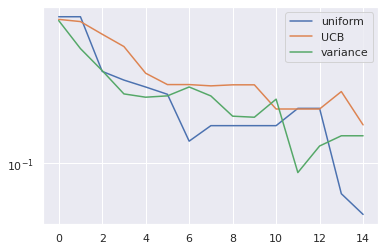

In [6]:

import ast
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
import glob

sns.set()

def load_data(path):
    with open(path, 'r') as f:
        raw_data = f.readlines()
    
    data = []
    for d in raw_data:
        dict_ = ast.literal_eval(d)

        if 'meta_game' in dict_.keys():
            dict_['meta_game'] = pkl.loads(dict_['meta_game'])
        if 'meta_strategies' in dict_.keys():
            dict_['meta_strategies'] = pkl.loads(dict_['meta_strategies'])

        data.append(dict_)
    return data

def is_done(lines, path):
    with open(path, 'r') as f:
        return len(f.readlines()) >= lines

def get_exploit(path):
    data = load_data(path)
    exploits = np.zeros(100)

    data = list(filter(lambda x: 'exploit' in x.keys(), data))
    for (i, d) in enumerate(data):
        exploits[i] += float(d['exploit'])

    return exploits

cutoff = 15
prd = 10000
N = 20
for g in [f'data_temp/baseline_uniform_{N}_{prd}*', 
        #   f'data_temp/random_sampler_{N}_{prd}*', 
          f'data_temp/simple_ucb_{N}_{prd}*',
          f'data_temp/variance_sampler_{N}_{prd}*']:
    files = glob.glob(g)
#     print(len(files))
    files = list(filter(lambda x: is_done(cutoff + 1, x), files))

    total_exp = np.zeros((len(files), cutoff))

    for (i, f) in enumerate(files):
        total_exp[i] = get_exploit(f)[:cutoff]

    mean_vals = np.mean(total_exp, axis=0)
    # max_vals = np.percentile(total_exp, 95, axis=0)
    # min_vals = np.percentile(total_exp, 5, axis=0)
    
    plt.yscale("log")
    plt.plot(mean_vals)
    # plt.fill_between(range(len(min_vals)), min_vals, max_vals, alpha=0.5)

plt.legend(["uniform", 
            # "random", 
            "UCB", 
            "variance"])
plt.show()


In [ ]:
samplers = [baseline_uniform, 
            variance_sampler, 
            simple_ucb, 
            # random_sampler
            ]
for i in range(1):
    for sampler in samplers:
        generate_data(prd=10000, N=200, data_dir='data_temp', sampler=sampler, steps=25)
        generate_data(prd=10000, N=100, data_dir='data_temp', sampler=sampler, steps=25)
        generate_data(prd=10000, N=50, data_dir='data_temp', sampler=sampler, steps=25)
        generate_data(prd=10000, N=10, data_dir='data_temp', sampler=sampler, steps=25)
        generate_data(prd=10000, N=5, data_dir='data_temp', sampler=sampler, steps=25)

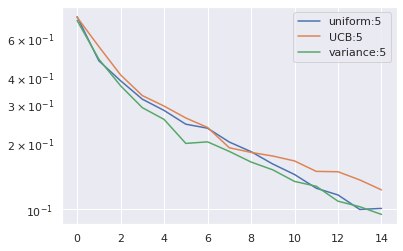

In [43]:

import ast
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
import glob

sns.set()

def load_data(path):
    with open(path, 'r') as f:
        raw_data = f.readlines()
    
    data = []
    for d in raw_data:
        dict_ = ast.literal_eval(d)

        if 'meta_game' in dict_.keys():
            dict_['meta_game'] = pkl.loads(dict_['meta_game'])
        if 'meta_strategies' in dict_.keys():
            dict_['meta_strategies'] = pkl.loads(dict_['meta_strategies'])

        data.append(dict_)
    return data

def is_done(lines, path):
    with open(path, 'r') as f:
        return len(f.readlines()) >= lines

def get_exploit(path):
    data = load_data(path)
    exploits = np.zeros(100)

    data = list(filter(lambda x: 'exploit' in x.keys(), data))
    for (i, d) in enumerate(data):
        exploits[i] += float(d['exploit'])

    return exploits

cutoff = 15
prd = 10000
N = 5
for g in [f'data_fixed/baseline_uniform_{N}_{prd}*', 
        #   f'data_temp/random_sampler_{N}_{prd}*', 
          f'data_fixed/simple_ucb_{N}_{prd}*',
        #   f'data_fixed/baseline_uniform_{100}_{prd}*',
        #   f'data_fixed/simple_ucb_{100}_{prd}*',
          f'data_fixed/variance_sampler_{N}_{prd}*']:
    files = glob.glob(g)
#     print(len(files))
    files = list(filter(lambda x: is_done(cutoff + 1, x), files))

    total_exp = np.zeros((len(files), cutoff))

    for (i, f) in enumerate(files):
        total_exp[i] = get_exploit(f)[:cutoff]

    mean_vals = np.mean(total_exp, axis=0)
    # max_vals = np.percentile(total_exp, 95, axis=0)
    # min_vals = np.percentile(total_exp, 5, axis=0)
    
    plt.yscale("log")
    plt.plot(mean_vals)
    # plt.fill_between(range(len(min_vals)), min_vals, max_vals, alpha=0.5)

plt.legend(["uniform:5", 
            # "random", 
            "UCB:5", 
            # "baseline_100",
            # "UCB:100",
            "variance:5"])
plt.show()


In [33]:
samplers = [baseline_uniform, 
            variance_sampler, 
            simple_ucb, 
            # random_sampler
            ]
for i in range(10):
    for sampler in samplers:
        generate_data(prd=10000, N=200, data_dir='data_fixed', sampler=sampler, steps=15)
        generate_data(prd=10000, N=100, data_dir='data_fixed', sampler=sampler, steps=15)
        generate_data(prd=10000, N=50, data_dir='data_fixed', sampler=sampler, steps=15)
        generate_data(prd=10000, N=10, data_dir='data_fixed', sampler=sampler, steps=15)
        generate_data(prd=10000, N=5, data_dir='data_fixed', sampler=sampler, steps=15)

avdizcgg
Using 200 sims per entry.
Rectifier : 
Perturbating oracle outputs : False
Sampling from marginals : True
Using <function nash_strategy at 0x7fd2eae06a60> as strategy method.
Using <function filter_function_factory.<locals>.filter_policies at 0x7fd36cb74ca0> as training strategy selector.


  0%|          | 0/15 [00:00<?, ?it/s]/mnt/c/Users/Geoff/Documents/Hannibal-final/samplers.py:20: RuntimeWarning: invalid value encountered in true_divide
  return meta / counts
/home/geoff/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 13%|█▎        | 2/15 [00:00<00:00, 14.35it/s]

budget=800
budget=1800
budget=3200


 27%|██▋       | 4/15 [00:00<00:01,  8.51it/s]

budget=5000
budget=7200


 40%|████      | 6/15 [00:00<00:01,  5.85it/s]

budget=9800
budget=12800


 47%|████▋     | 7/15 [00:01<00:01,  5.02it/s]

budget=16200


 53%|█████▎    | 8/15 [00:01<00:01,  4.32it/s]

budget=20000


 60%|██████    | 9/15 [00:01<00:01,  3.33it/s]

budget=24200


 67%|██████▋   | 10/15 [00:02<00:01,  3.05it/s]

budget=28800


 73%|███████▎  | 11/15 [00:02<00:01,  2.88it/s]

budget=33800


 80%|████████  | 12/15 [00:03<00:01,  2.75it/s]

budget=39200


 87%|████████▋ | 13/15 [00:03<00:00,  2.52it/s]

budget=45000


 93%|█████████▎| 14/15 [00:04<00:00,  3.26it/s]

budget=51200


KeyboardInterrupt: 

/home/geoff/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/geoff/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/geoff/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/geoff/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/geoff/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/geoff/.local/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


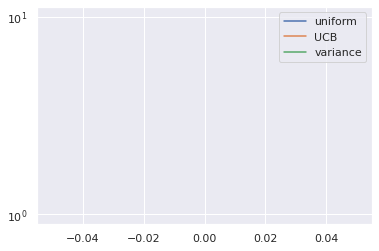

In [15]:

import ast
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
import glob

sns.set()

def load_data(path):
    with open(path, 'r') as f:
        raw_data = f.readlines()
    
    data = []
    for d in raw_data:
        dict_ = ast.literal_eval(d)

        if 'meta_game' in dict_.keys():
            dict_['meta_game'] = pkl.loads(dict_['meta_game'])
        if 'meta_strategies' in dict_.keys():
            dict_['meta_strategies'] = pkl.loads(dict_['meta_strategies'])

        data.append(dict_)
    return data

def is_done(lines, path):
    with open(path, 'r') as f:
        return len(f.readlines()) >= lines

def get_exploit(path):
    data = load_data(path)
    exploits = np.zeros(100)

    data = list(filter(lambda x: 'exploit' in x.keys(), data))
    for (i, d) in enumerate(data):
        exploits[i] += float(d['exploit'])

    return exploits

cutoff = 20
prd = 10000
N = 200
for g in [f'data_temp/baseline_uniform_{N}_{prd}*', 
        #   f'data_temp/random_sampler_{N}_{prd}*', 
          f'data_temp/simple_ucb_{N}_{prd}*',
          f'data_temp/variance_sampler_{N}_{prd}*']:
    files = glob.glob(g)
#     print(len(files))
    files = list(filter(lambda x: is_done(cutoff + 1, x), files))

    total_exp = np.zeros((len(files), cutoff))

    for (i, f) in enumerate(files):
        total_exp[i] = get_exploit(f)[:cutoff]

    mean_vals = np.mean(total_exp, axis=0)
    # max_vals = np.percentile(total_exp, 95, axis=0)
    # min_vals = np.percentile(total_exp, 5, axis=0)
    
    plt.yscale("log")
    plt.plot(mean_vals)
    # plt.fill_between(range(len(min_vals)), min_vals, max_vals, alpha=0.5)

plt.legend(["uniform", 
            # "random", 
            "UCB", 
            "variance"])
plt.show()


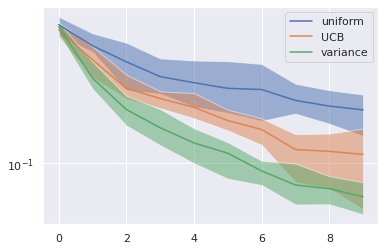

In [17]:

import ast
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
import glob

sns.set()

def load_data(path):
    with open(path, 'r') as f:
        raw_data = f.readlines()
    
    data = []
    for d in raw_data:
        dict_ = ast.literal_eval(d)

        if 'meta_game' in dict_.keys():
            dict_['meta_game'] = pkl.loads(dict_['meta_game'])
        if 'meta_strategies' in dict_.keys():
            dict_['meta_strategies'] = pkl.loads(dict_['meta_strategies'])

        data.append(dict_)
    return data

def is_done(lines, path):
    with open(path, 'r') as f:
        return len(f.readlines()) >= lines

def get_exploit(path):
    data = load_data(path)
    exploits = np.zeros(100)

    data = list(filter(lambda x: 'exploit' in x.keys(), data))
    for (i, d) in enumerate(data):
        exploits[i] += float(d['exploit'])

    return exploits

cutoff = 10
prd = 10000
N = 100
for g in [f'data_temp/baseline_uniform_{1}_{prd}*', 
          f'data_temp/baseline_uniform_{10}_{prd}*', 
          f'data_temp/baseline_uniform_{100}_{prd}*',
        #   f'data_temp/variance_sampler_{N}_{prd}*'
          ]:
    files = glob.glob(g)
#     print(len(files))
    files = list(filter(lambda x: is_done(cutoff + 1, x), files))

    total_exp = np.zeros((len(files), cutoff))

    for (i, f) in enumerate(files):
        total_exp[i] = get_exploit(f)[:cutoff]

    mean_vals = np.mean(total_exp, axis=0)
    max_vals = np.percentile(total_exp, 95, axis=0)
    min_vals = np.percentile(total_exp, 5, axis=0)
    
    plt.yscale("log")
    plt.plot(mean_vals)
    plt.fill_between(range(len(min_vals)), min_vals, max_vals, alpha=0.5)

plt.legend(["uniform", 
            # "random", 
            "UCB", 
            "variance"])
plt.show()


In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--prd", default=10000, type=int, help="Number of PRD steps")
# parser.add_argument("--N", default=10, type=int, help="Samples Per Interaction")
# parser.add_argument("--sampler", default="ucb", help="Name of sampler")
# parser.add_argument("--dir", default="data", help="output_directory")
# args = parser.parse_args()

# sampler = None
# if args.sampler == "baseline_uniform":
#     sampler = baseline_uniform
# elif args.sampler == "ucb":
#     sampler = ucb
# elif args.sampler == "simple_ucb":
#     sampler = simple_ucb

# samplers = [baseline_uniform, ucb, simple_ucb]
# for sampler in samplers:
#     main(args.prd, args.N, args.dir, sampler)

n10_matricies = [generate_data(prd=10000, N=10, data_dir='data', sampler=baseline_uniform, steps=6) for i in range(5)]
n100_matricies = [generate_data(prd=10000, N=100, data_dir='data', sampler=baseline_uniform, steps=6) for i in range(5)]
n1000_matricies = [generate_data(prd=10000, N=1000, data_dir='data', sampler=baseline_uniform, steps=6) for i in range(5)]

In [ ]:
np.mean(n10_matricies, axis=0).round(2), np.mean(n100_matricies, axis=0), np.mean(n1000_matricies, axis=0)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize = (15,30))
vmin, vmax = -1, 1
ax[0].imshow(np.mean(n10_matricies, axis=0).round(2), cmap = 'coolwarm', vmin = vmin, vmax = vmax)
ax[1].imshow(np.mean(n100_matricies, axis=0).round(2), cmap = 'coolwarm', vmin = vmin, vmax = vmax)
ax[2].imshow(np.mean(n1000_matricies, axis=0).round(2), cmap = 'coolwarm', vmin = vmin, vmax = vmax)
plt.show()

In [ ]:
np.min(n10_matricies)

In [ ]:
policies = []
for i in range(5):
    policies.append((5,j))
    policies.append((5,i))
policies.append((5,5))

In [ ]:
np.random.choice(len(policies))

In [ ]:
n10_matricies = generate_data(prd=10000, N=10, data_dir='data', sampler=random_sampler, steps=20)

In [ ]:
random_sampler